In [1]:
import re
from typing import List, Tuple

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec, FastText
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from src.dataset import read_lang_dataset, tokenize_dataset, tokenize_document, get_vocab_mapping, gateways

sns.set_theme()
sns.set(rc={'figure.figsize': (12, 8)})

In [2]:
dataset = read_lang_dataset('data/dataset_github_codes.db')
dataset

,language,code
0,Python,"""""""The tests for the automation component.""""""\..."
1,Python,#!python2\n# -*- coding: utf-8 -*-\nimport os\...
2,Python,#!/usr/bin/python\n#\n# Copyright (c) 2017 Yuw...
3,Python,"""""""The tests for the Template automation.""""""\n..."
4,Python,"""""""The tests for numeric state automation.""""""\..."
...,...,...
9467,C#,using Microsoft.SharePoint.Client;\nusing Micr...
9468,C#,using System;\nusing System.Collections;\nusin...
9469,C#,using UnityEngine;\nusing System.Collections.G...
9470,C#,// Copyright (c) Microsoft Corporation. All ri...


In [3]:
dataset.language.value_counts()

C++       2688
C#        2493
Go        2203
Python    2088
Name: language, dtype: int64

In [4]:
use_cache = True
# load "tokenized_sample.pkl" from disk if it exists
if use_cache and os.path.exists("models/tokenized_sample.pkl"):
    tokenized_sample = pd.read_pickle("models/tokenized_sample.pkl")
else:
    tokenized_sample = tokenize_dataset(dataset)
    tokenized_sample.to_pickle("models/tokenized_sample.pkl")

tokenized_sample

,language,code
0,Python,"[STRING_LITERAL, \n, from, datetime, import, t..."
1,Python,"[\n, import, os, \n, import, sys, \n, import, ..."
2,Python,"[\n, from, __future__, import, absolute_import..."
3,Python,"[STRING_LITERAL, \n, import, unittest, \n, fro..."
4,Python,"[STRING_LITERAL, \n, from, datetime, import, t..."
...,...,...
9467,C#,"[using, Microsoft, ., SharePoint, ., Client, ;..."
9468,C#,"[using, System, ;, using, System, ., Collectio..."
9469,C#,"[using, UnityEngine, ;, using, System, ., Coll..."
9470,C#,"[using, System, ;, using, System, ., Collectio..."


In [5]:
def create_lang_model(dataset, complete_model, language):
    model = Word2Vec.load("models/complete_model.gensim")
    #model = FastText.load("models/complete_model.gensim")
    #model = Word2Vec(vector_size=100, window=10, min_count=10, workers=4)
    #model.reset_from(complete_model)
    #model.init_weights()
    train_dataset = dataset.code[dataset.language == language]
    model.train(train_dataset, total_examples=len(train_dataset), epochs=5)
    return model

In [6]:
common_keywords = ["if", "else", "for", "while", "class", "struct", "return", "continue", "break", "var", "try", "catch", "except"]
semantic_symbols = ["{", "}", ":"]

language_specific_words = common_keywords + semantic_symbols

In [7]:
from functools import partial


def add_language_prefix(code, language):
    return [f"{language}_{keyword}" if keyword in language_specific_words else keyword for keyword in code]

for language in tokenized_sample.language.unique():
    tokenized_sample.loc[tokenized_sample.language == language, "code"] = tokenized_sample[tokenized_sample.language == language].code.apply(partial(add_language_prefix, language=language))

In [8]:
#complete_model = FastText(vector_size=100, window=5, min_count=5, workers=8)
complete_model_w2v = Word2Vec(vector_size=500, window=5, min_count=10, workers=8)
complete_model = FastText(vector_size=100, window=5, min_count=10, workers=8)
complete_model.build_vocab(tokenized_sample.code)
complete_model.train(tokenized_sample.code, total_examples=complete_model.corpus_count, epochs=5)
complete_model

# Visualize

In [9]:
inserted_tokens = ["INT_LITERAL", "FLOAT_LITERAL", "STRING_LITERAL", "VARIABLE"]
math_ops = ["+", "-", "*", "/", "%", "&&", "||", "!", "&", "|"]

python_keywords = ["def", "class", "return", "if", "else", "for", "while", "in", "import", "from", "as", "with", "try", "except", "finally", "raise", "assert", "yield", "lambda", "pass", "break", "continue", "del", "global", "nonlocal", "and", "or", "not", "is", "in", "True", "False", "None", "async", "await"]
cpp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
csharp_keywords = ["class", "bool", "catch", "try", "break", "continue", "delete", "do", "else", "enum", "explicit", "export", "extern", "false", "for", "friend", "goto", "if", "inline", "mutable", "namespace", "new", "operator", "private", "protected", "public", "register", "return", "sizeof", "static", "struct", "switch", "template", "this", "throw", "true", "typedef", "typeid", "typename", "union", "using", "virtual", "volatile", "while"]
go_keywords = ["break", "func", "default", "type", "defer", "go", "struct", "map", "chan", "else", "goto", "package", "range", "const", "fallthrough", "for", "import", "interface", "return", "select", "case", "continue", "if", "switch", "var", "nil", "true", "false"]

In [10]:
def word_cloud(model: Word2Vec, words):
    words = [word for word in words if word in model.wv.key_to_index.keys()]
    word_vectors = np.array([model.wv.get_normed_vectors()[model.wv.key_to_index[word]] for word in words])
    pca = PCA(n_components=2)
    result = pca.fit_transform(word_vectors)

    df = pd.DataFrame(result, columns=["x", "y"])
    df["model"] = [word.split("_")[0] if len(word.split("_")) == 2 else "" for word in words]
    ax = sns.scatterplot(data=df, x="x", y="y", hue="model")
    range_x, range_y = np.ptp(df[["x", "y"]], axis=0)
    keywords = [word.split("_")[1] if len(word.split("_")) == 2 else word for word in words]
    for i, word in enumerate(keywords):
        x, y = result[i]
        ax.text(x + 0.005 * range_x, y, word, verticalalignment='center', horizontalalignment='left', fontsize=8)
    return ax

<AxesSubplot: xlabel='x', ylabel='y'>

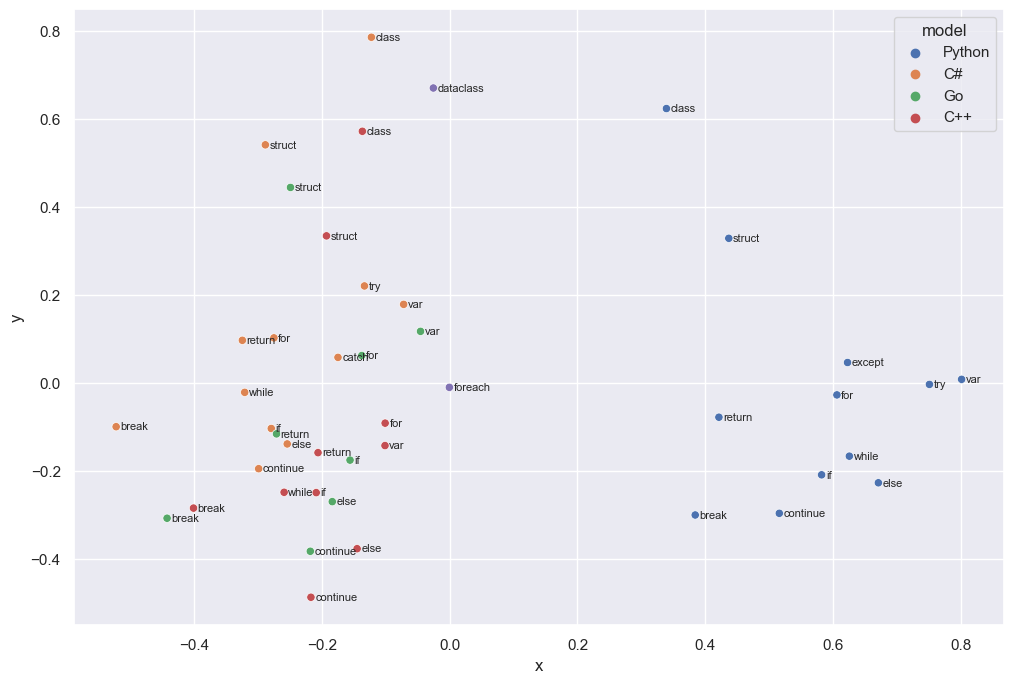

In [11]:
word_cloud(complete_model, [f"{language}_{w}" for w in common_keywords for language in tokenized_sample.language.unique()] + ["foreach", 'dataclass'])

In [12]:
python_codes = tokenized_sample[tokenized_sample["language"] == 'Python']

python_model = FastText(vector_size=100, window=5, min_count=10, workers=8, sg=1)
python_model.build_vocab(python_codes.code)
python_model.train(python_codes.code, total_examples=python_model.corpus_count, epochs=5)
python_model


In [13]:
python_code_example = """#!/usr/bin/env python3

import os

def main():
    query = 7
    context = [3, 4, 10, 2, 8, 6, 5, 9, 7, 1]
    for i in range(len(context)):
        if context[i] == query:
            print(f'Query found at index {i}')
            os.exit(0)    

    print(f'Coulnd't find query {query}')
    os.exit(-1)


if __name__ == '__main__':
    main()

}"""

tokenized_code_example = tokenize_document(python_code_example, "Python")
tokenized_code_example = add_language_prefix(tokenized_code_example, "Python")
for word in tokenized_code_example:
    print(f' {word}', end="")

def next_similar_token(token: str) -> str:
    next_most_similar_token, _ = complete_model.wv.most_similar(positive=[token])[0]
    return next_most_similar_token

print('-'* 20)

next_similar_document = ' '.join([next_similar_token(t) for t in tokenized_code_example])
next_similar_document = next_similar_document.replace(':', ':\n')
print(next_similar_document)


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

 
 import os 
 def main ( ) Python_:        VARIABLE = FLOAT_LITERAL   VARIABLE = [ FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL , FLOAT_LITERAL ]   Python_for i in range ( len ( VARIABLE ) ) Python_:            Python_if VARIABLE [ i ] == VARIABLE Python_:                print ( STRING_LITERAL )   os . exit ( FLOAT_LITERAL )       VARIABLE ( STRING_LITERAL VARIABLE VARIABLE VARIABLE Python_{ VARIABLE Python_}   os . exit ( - FLOAT_LITERAL ) 
 
 Python_if __name__ == STRING_LITERAL Python_:        main ( ) 
 
 <EOF>--------------------


 importlib osp 

 ifsdef iommu_domain VARIANT_FALSE lirelettre PythonCAD Python_:
     VARIANT pop INT_LITERAL Python_:
 VARIANT pop rule_5 INT_LITERAL CURLU_DEFAULT_SCHEME INT_LITERAL CURLU_DEFAULT_SCHEME INT_LITERAL CURLU_DEFAULT_SCHEME INT_LITERAL CURLU_DEFAULT_SCHEME INT_LITERAL CURLU_DEFAULT_SCHEME INT_LITERAL CURLU_DEFAULT_SCHEME INT_LITERAL CURLU_DEF

In [14]:
recent_tokens = ['import', 'os']

for i in range(20):
    next_tokens = python_model.predict_output_word(recent_tokens[-5:])

    token_found = False
    for t, _ in next_tokens:
        if t in recent_tokens[-5:] and t not in ['import', ',']:
            continue

        recent_tokens.append(t)
        print(t, end=' ')
        token_found = True

    if not token_found:
        t, _ = next_tokens[0]
        recent_tokens.append(t)
        print(t, end=' ')


shutil re bs4 system import requests random base64 threading sys import bs4 platform 	 subprocess 
 sys random stdout re import string exit sys random re subprocess string time 	 
 requests 		 random time print system sleep ConnectionError 	 Public 			 		 sleep print time Public requests Main ConnectionError sleep 			 	 time 		 Public ConnectionError exceptions print 	 			 		 requests Python_except Public print sleep ConnectionError 	 		 Public 			 print requests sleep time public_menu 	 		 ConnectionError 			 requests system Public 		 	 			 ConnectionError print exceptions Python_except Public time ConnectionError 	 			 exceptions requests 		 sleep print login 	 ConnectionError requests sleep 			 time input system print 	 		 			 Main requests input 	 		 print 			 
	 old system sleep 	 		 print Main system 			 
	 old time 		 	 print system sleep Main 			 time 
	 requests sleep 	 		 print time system Public Main ConnectionError sleep 	 		 time Main print 			 system Public requests 		 	 

Number to different tokens: 36150
10 most frequent tokens for Python:
 VARIABLE: 524241
 ,: 337469
 STRING_LITERAL: 315775
 .: 306763
  : 298737
 (: 271330
 ): 269726
 =: 177147
 Python_:: 151609
 FLOAT_LITERAL: 77898
Number to different tokens: 46677
10 most frequent tokens for C#:
 .: 337464
 VARIABLE: 282619
 (: 227667
 ): 227622
 ;: 210292
 ,: 118142
 =: 102123
 C#_{: 90397
 C#_}: 88813
 STRING_LITERAL: 70338
Number to different tokens: 31247
10 most frequent tokens for Go:
 VARIABLE: 577861
 ,: 491687
 .: 407431
 (: 342090
 ): 342053
 
: 260226
 STRING_LITERAL: 185375
 INT_LITERAL: 166587
 Go_{: 147162
 Go_}: 147109
Number to different tokens: 51581
10 most frequent tokens for C++:
 VARIABLE: 527661
 ,: 362480
 ;: 362319
 (: 348119
 ): 347616
 INT_LITERAL: 146625
 ->: 124351
 *: 122931
 =: 116561
 C++_{: 90082


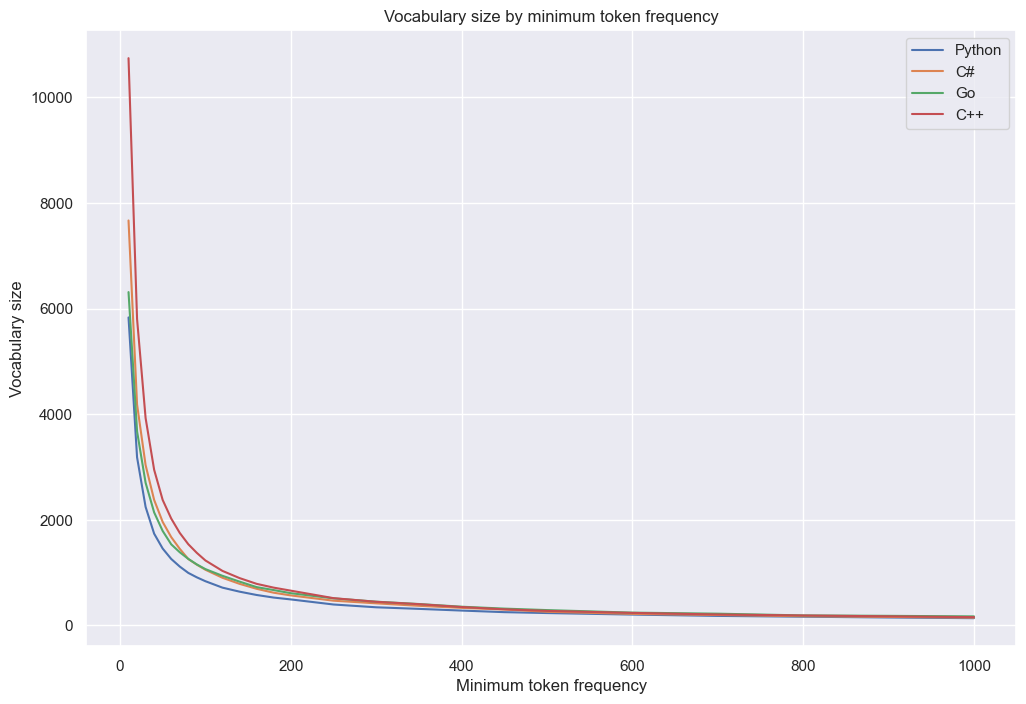

In [56]:
most_frequent_tokens = {}
for language in tokenized_sample.language.unique():
    code_for_language = tokenized_sample[tokenized_sample["language"] == language]
    token_frequency = {}
    for code in code_for_language.code:
        for token in code:
            token_frequency[token] = token_frequency.get(token, 0) + 1
    print(f'Number to different tokens: {len(token_frequency)}')

    token_frequency_sorted = sorted(token_frequency.items(), key=lambda x: x[1], reverse=True)
    most_frequent_tokens[language] = token_frequency_sorted[0:3]
    print(f'10 most frequent tokens for {language}:')
    for token, freq in token_frequency_sorted[:10]:
        print(f' {token}: {freq}')

    token_frequency_meta = {}
    for m in [10,20,30,40,50,60,70,80,90,100, 120, 140, 160, 180, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000]:
        for token, freq in token_frequency.items():
            if freq >= m:
                token_frequency_meta[m] = token_frequency_meta.get(m, 0) + 1
    plt.plot(list(token_frequency_meta.keys()), list(token_frequency_meta.values()), label=language)

plt.title('Vocabulary size by minimum token frequency')
plt.xlabel('Minimum token frequency')
plt.ylabel('Vocabulary size')
plt.legend()
plt.show()

In [16]:
complete_model.wv.most_similar(positive=['C++_if'], negative=['Python_if', 'C#_if'])


[('HIWORD', 0.38304567337036133),
 ('PHP_POSIX_NO_ARGS', 0.36087682843208313),
 ('PHP_POSIX_RETURN_LONG_FUNC', 0.3482794463634491),
 ('_DWORD', 0.33336538076400757),
 ('OSI_FUNCS_TIME_BLOCKING', 0.3303515911102295),
 ('DWORD', 0.3292984664440155),
 ('O_TRUNC', 0.3249448537826538),
 ('MAX_CAPACITY_NUM', 0.32314446568489075),
 ('PHP_POSIX_SINGLE_ARG_FUNC', 0.3219619691371918),
 ('WORD', 0.31303200125694275)]

In [30]:
average_token_length = {}
for language in tokenized_sample.language.unique():
    code_for_language = tokenized_sample[tokenized_sample["language"] == language].code
    
    # get average code length for all elements in code_for_language. round to 2 decimals
    code_lengths = [len(code) for code in code_for_language]
    average_token_length[language] = round(sum(code_lengths) / len(code_lengths), 2)
    #print(f'Average amount of tokens for {language}: {average_code_length}')

In [71]:
# most_frequent_tokens is a list of tuples (token, frequency) for each language
# we want to print the token, so we need to extract it from the tuple and join it with a comma. surround each token with backticks to make it a code block
joined_tokens = {language: '  '.join([token for token, _ in tokens]) for language, tokens in most_frequent_tokens.items()}

# make a markdown table with one column per language
print('|    | C++ | Go | C# | Python |')
print('|---|---|---|---|---|')
print(f'| Avg. tokens per file | {average_token_length["C++"]} | {average_token_length["Go"]} | {average_token_length["C#"]} | {average_token_length["Python"]} |')
print(f'| Most frequent token | {most_frequent_tokens["C++"][0][0]} | {most_frequent_tokens["Go"][0][0]} | {most_frequent_tokens["C#"][0][0]} | {most_frequent_tokens["Python"][0][0]} |')
print(f'| 2nd most frequent token | {most_frequent_tokens["C++"][1][0]} | {most_frequent_tokens["Go"][1][0]} | {most_frequent_tokens["C#"][1][0]} | {most_frequent_tokens["Python"][1][0]} |')
print(f'| 3rd most frequent token | {most_frequent_tokens["C++"][2][0]} | {most_frequent_tokens["Go"][2][0]} | {most_frequent_tokens["C#"][2][0]} | {most_frequent_tokens["Python"][2][0]} |')
print(f'| Number of keywords | 95 | 25 | 79 | 33 |')

|    | C++ | Go | C# | Python |
|---|---|---|---|---|
| Avg. tokens per file | 1545.66 | 2136.9 | 1218.43 | 1889.92 |
| Most frequent keyword | VARIABLE | VARIABLE | . | VARIABLE |
| 2nd most frequent keyword | , | , | VARIABLE | , |
| 3rd most frequent keyword | ; | . | ( | STRING_LITERAL |
| Number of keywords | 95 | 25 | 79 | 33 |


|    | C++ | Go | C# | Python |
|---|---|---|---|---|
| Avg. tokens per file | 1545.66 | 2136.9 | 1218.43 | 1889.92 |
| Most frequent keyword | VARIABLE | VARIABLE | . | VARIABLE |
| 2nd most frequent keyword | , | , | VARIABLE | , |
| 3rd most frequent keyword | ; | . | ( | STRING_LITERAL |
| Number of keywords | 95 | 25 | 79 | 33 |